<a href="https://colab.research.google.com/github/shachiii/Intent-Recognition-BERT-/blob/master/Intent_Recognition_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [1]:
!pip install tensorflow-gpu >> /dev/null

In [2]:
!pip install --upgrade grpcio >> /dev/null

In [3]:
!pip install tqdm  >> /dev/null

In [4]:
!pip install bert-for-tf2 >> /dev/null #bert was made for tf 1 so this libary handles the change

In [5]:
!pip install sentencepiece >> /dev/null

In [6]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')

In [8]:
train = train.append(valid).reset_index(drop=True)

In [9]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


We know want to check whether all the intents and evenly spread out in the data i.e. to find out if our data is balanced

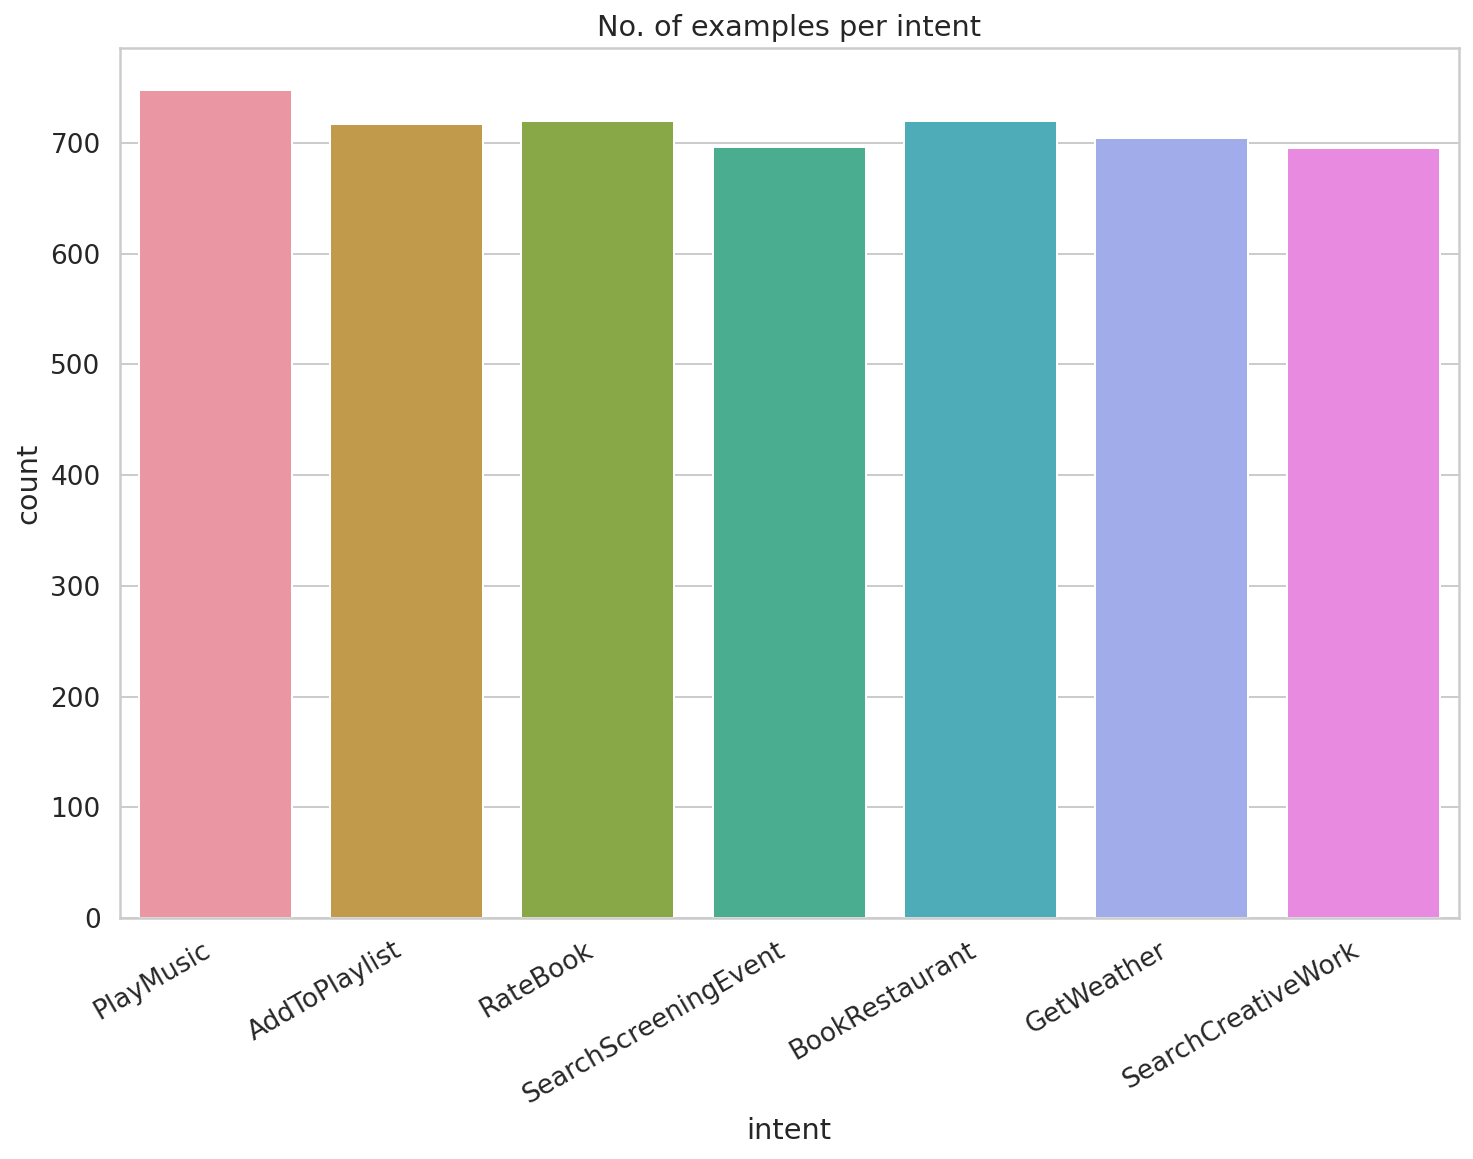

In [10]:
chart = sns.countplot(train[:5000].intent)
plt.title('No. of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

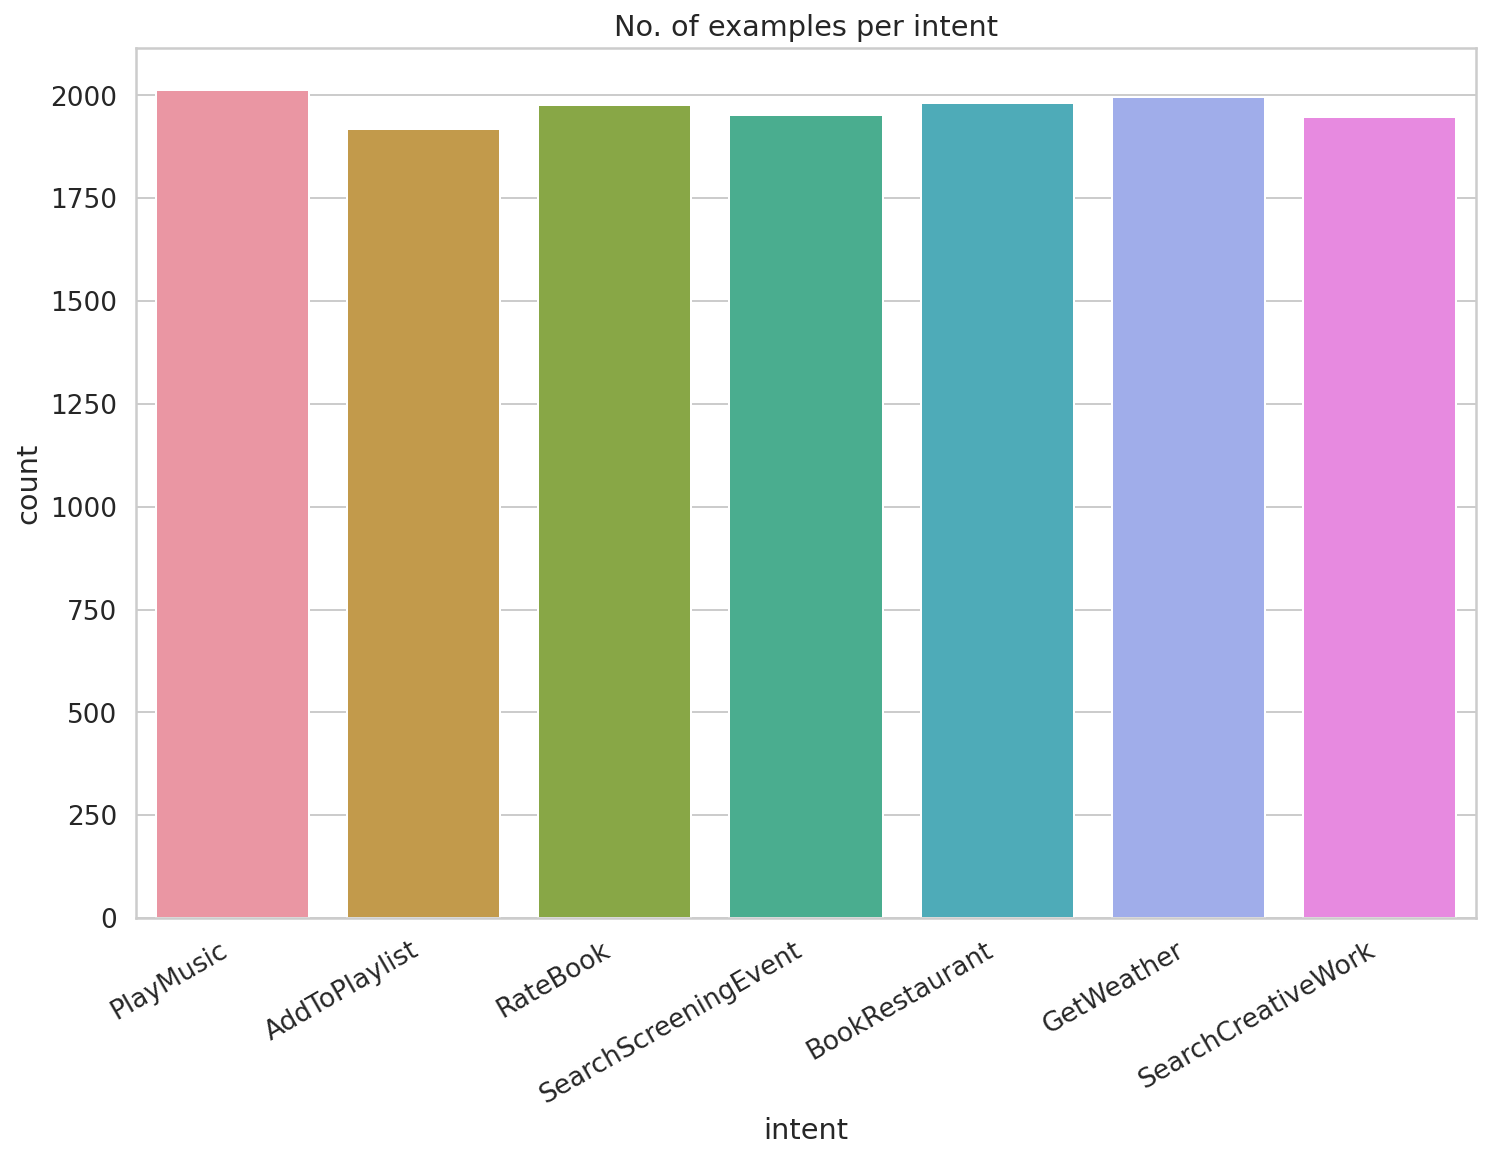

In [16]:
chart = sns.countplot(train.intent)
plt.title('No. of examples per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

As we can see, there are roughly 2000 text queries for each intent, making the data fairly balanced.

Downloading bert

In [6]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip -P "/content/drive/My Drive/gpu_test"

--2020-07-09 09:38:28--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘/content/drive/My Drive/gpu_test/uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  43.9MB/s    in 9.2s    

2020-07-09 09:38:37 (42.4 MB/s) - ‘/content/drive/My Drive/gpu_test/uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [8]:
!unzip "/content/drive/My Drive/gpu_test/uncased_L-12_H-768_A-12.zip"

Archive:  /content/drive/My Drive/gpu_test/uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


Making a new folder called model and moving everything there

In [9]:
os.makedirs('model', exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

In [11]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

Preprocessing

In [21]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


# Data Preprocessing

In the following class, we will define 2 methods-


1.   _prepare()
2.   _pad()

Data that will be passed on to BERT needs to be in a certain way. 
- The textual data needs to first be tokenized before being sent to the model. We will use BERT's inbuilt tokenizer for this purpose.
- Further, inputs need to start with a token id called [CLS] and end with another token id called [SEP].
- We have to modify the inputs accordingly.
- All the inputs must have the same lengths.
- This means that inputs shorter than the cut off length must have some sort of padding for it. We will be padding with zeroes.




In [12]:
class IntentDetectionData:
  DATA_COLUMN ='text'
  LABEL_COLUMN ='intent'

  #constructor
  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    #the _prepare method will be defined 
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train,test])
    
    print("max seq_len", self.max_seq_len)
    #max_seq_len can be 192 or less, so we'll take the max from the train/test data
    self.max_seq_len = min(self.max_seq_len, max_seq_len)

    #for inputs that are shorter than max_seq_len, we will pad the input with zeroes
    #this is because BERT requires that all inputs be of the same length
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []

    for _,row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      #create tokens
      tokens = self.tokenizer.tokenize(text)
      #BERT requires every input to have 2 ids, CLS at the start and SEP at the end
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      #getting the max length
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      
      #add data
      x.append(token_ids)
      y.append(self.classes.index(label))
    
    return np.array(x), np.array(y)


  def _pad(self, ids): #function takes in ids that have been returned by the prepare function
    x = []

    for input_ids in ids:
      #the actual length of the ids, will be the seq len - 2 as we had added CLS and SEP
      cut_point = min(len(input_ids), self.max_seq_len - 2)
      input_ids = input_ids[:cut_point]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      
      x.append(np.array(input_ids))

    return np.array(x)

In [13]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [14]:
tokenizer.tokenize("I can't wait to visit Mumbai again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'mumbai', 'again', '!']

In [15]:
tokens = tokenizer.tokenize("I can't wait to visit Mumbai again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8955, 2153, 999]

# Creating the model

In [17]:
def create_model(max_seq_len, bert_ckpt_file):

  #opening the config file using tensorflow
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    #We are using the final model layer from the 12 layers
    bert = BertModelLayer.from_params(bert_params, name="bert")
        
  
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape:", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model 

In [18]:
test.shape

(700, 2)

# Training

In [19]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train[:5000], test, tokenizer, classes, max_seq_len=128)

5000it [00:02, 2333.10it/s]
700it [00:00, 2443.60it/s]


max seq_len 35


In [20]:
data.train_x.shape

(5000, 35)

In [21]:
data.train_x[0]

array([ 4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,  2006,
        8224,  2189,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

In [46]:
data.train_y[0]

0

In [35]:
data.max_seq_len

35

In [22]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape: (None, 35, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6311003ef0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 35)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 35, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [24]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [25]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
282/282 [==============================] - 168s 594ms/step - loss: 1.5591 - acc: 0.6273 - val_loss: 1.3214 - val_acc: 0.8400
Epoch 2/5
282/282 [==============================] - 163s 577ms/step - loss: 1.2315 - acc: 0.9449 - val_loss: 1.2061 - val_acc: 0.9580
Epoch 3/5
282/282 [==============================] - 163s 577ms/step - loss: 1.1954 - acc: 0.9736 - val_loss: 1.2038 - val_acc: 0.9620
Epoch 4/5
282/282 [==============================] - 163s 577ms/step - loss: 1.1878 - acc: 0.9798 - val_loss: 1.2020 - val_acc: 0.9640
Epoch 5/5
282/282 [==============================] - 162s 575ms/step - loss: 1.1807 - acc: 0.9860 - val_loss: 1.1885 - val_acc: 0.9780


In [26]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

22/22 [==============================] - 5s 236ms/step - loss: 1.2024 - acc: 0.9629
train acc 0.9886000156402588
test acc 0.9628571271896362


In [27]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [28]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.94      0.94      0.94        86
       AddToPlaylist       0.99      0.98      0.98       124
            RateBook       0.98      1.00      0.99        80
SearchScreeningEvent       1.00      0.88      0.94       107
      BookRestaurant       0.98      1.00      0.99        92
          GetWeather       1.00      0.98      0.99       104
  SearchCreativeWork       0.87      0.97      0.92       107

            accuracy                           0.96       700
           macro avg       0.96      0.96      0.96       700
        weighted avg       0.97      0.96      0.96       700



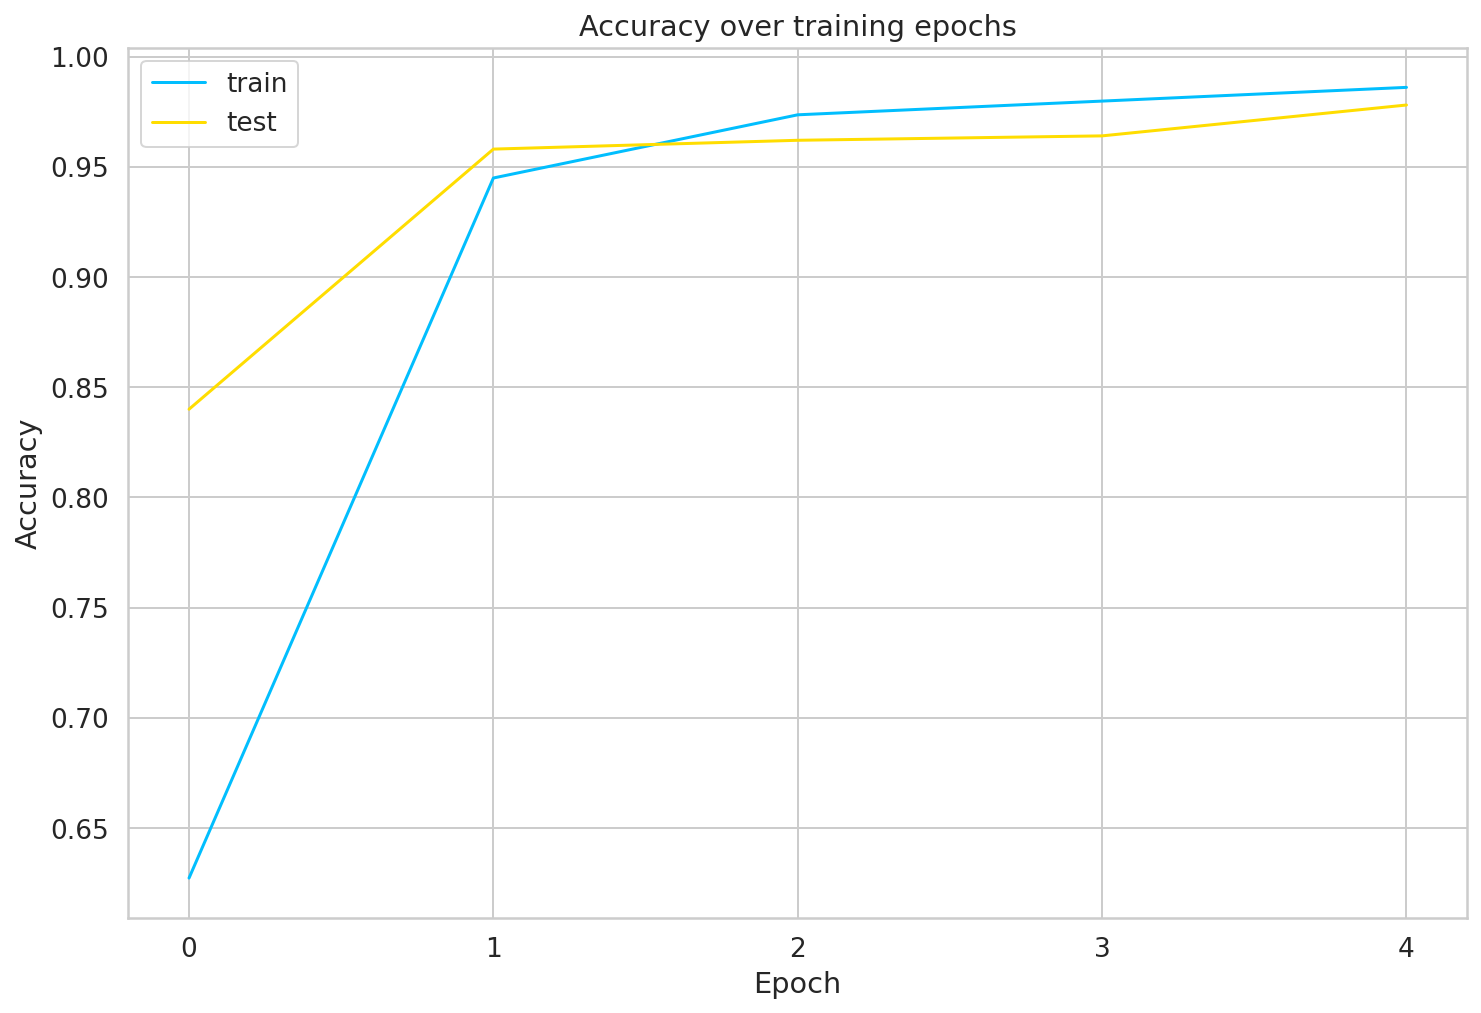

In [31]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [32]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

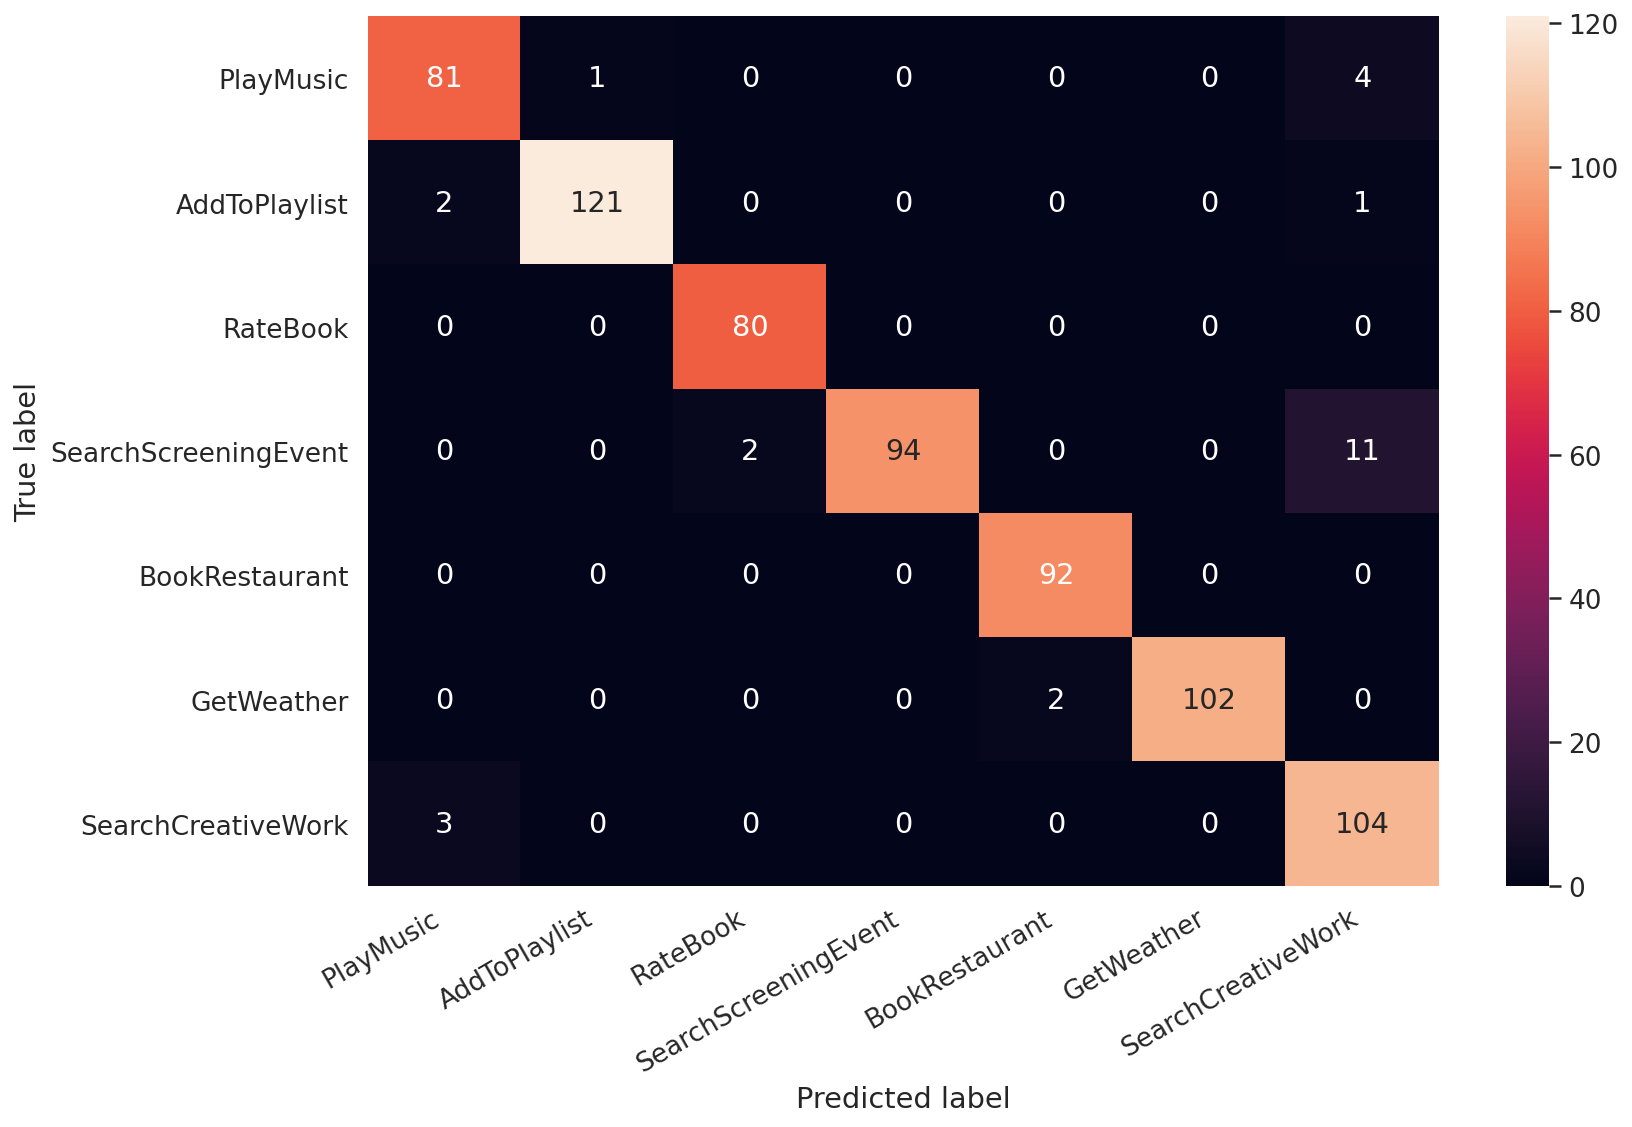

In [33]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [29]:
sentences = [
  "Play our song",
  "rate normal people 2 out of 5",
  "will it be sunny tomorrow",
  "reserve a table for 2",
  "what is the movie schedule in mumbai",
  "i want to eat at the cafe tomorrow",
  "play some blues"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song 
intent: SearchCreativeWork

text: rate normal people 2 out of 5 
intent: RateBook

text: will it be sunny tomorrow 
intent: GetWeather

text: reserve a table for 2 
intent: BookRestaurant

text: what is the movie schedule in mumbai 
intent: SearchScreeningEvent

text: i want to eat at the cafe tomorrow 
intent: BookRestaurant

text: play some blues 
intent: PlayMusic

